In [2]:
#importing all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import string
from tqdm import tqdm
import pickle
from sklearn.metrics import fbeta_score
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import csv
from collections import defaultdict
from collections import Counter
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.utils import register_keras_serializable
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import itertools
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
#loading the required data  (test and train are interchanged because with neural networks size wasn't an issue anymore)
X_test,y_test,X_train,y_train = np.load('/kaggle/input/dal-train/embed_train.npy'),np.load('/kaggle/input/dal-train/labels_train.npy'),np.load('/kaggle/input/dal-train/embed_test.npy'),np.load('/kaggle/input/dal-train/labels_test.npy')
real_test = np.load('/kaggle/input/dal-train/test_data.npy')

In [ ]:
'''Code for loading data and removing the duplicate embeddings with misleading labels'''
# da1 = np.load('embeddings_1.npy')
# da2 = np.load('embeddings_2.npy')
# da_all = np.vstack([da1,da2])
# labels1 = pd.read_csv('icd_codes_1.txt',header = None)
# labels1 = labels1[0].str.split(';')
# labels2 = pd.read_csv('icd_codes_2.txt',header = None)
# labels2 = labels2[0].str.split(';')
# labels_all = pd.concat([labels1,labels2],axis = 0)
# labels_all_tup = pd.Series([tuple(list) for list in labels_all])
# data = pd.DataFrame(da_all)
# data['Multilabels'] = labels_all_tup
# data_uni = data.drop_duplicates(subset = data.columns[:-1],keep = False)
# X,y = np.array(data_uni.iloc[:,:-1]),data_uni.iloc[:,-1]

In [4]:
alphabets = list(string.ascii_uppercase)

In [ ]:
#mlb = MultiLabelBinarizer().fit(y_train)
#mlb_letter = MultiLabelBinarizer().fit(y_starter_train)
with open('/kaggle/input/dal-train/mlb.pkl','rb') as file:
    mlb = pickle.load(file)
with open('/kaggle/input/dal-train/mlb_letter.pkl','rb') as file:
    mlb_letter = pickle.load(file)

In [6]:
y_labels_train = mlb.inverse_transform(y_train)
y_labels_test = mlb.inverse_transform(y_test)

In [7]:
y_starter_train = [tuple(s[0] for s in tup) for tup in y_labels_train]
y_starter_test = [tuple(s[0] for s in tup) for tup in y_labels_test]

In [8]:
y_train_letter = mlb_letter.transform(y_starter_train)
y_test_letter = mlb_letter.transform(y_starter_test)

In [29]:
'''Utility function for plotting the label distribution'''
# def labels_in_cluster(cluster,labels_uni):
#     '''
#     cluster is a list of characters
#     '''
#     results = {}
#     labels_all = [label for item in labels_uni for label in item]
#     for cat in cluster:
#         # print(set([label for label in labels_all if cat in label]))
#         results[cat] = len(set([label for label in labels_all if label.startswith(cat)]))
#     return results
# label_dist_true = labels_in_cluster(alphabets,y_labels_train)

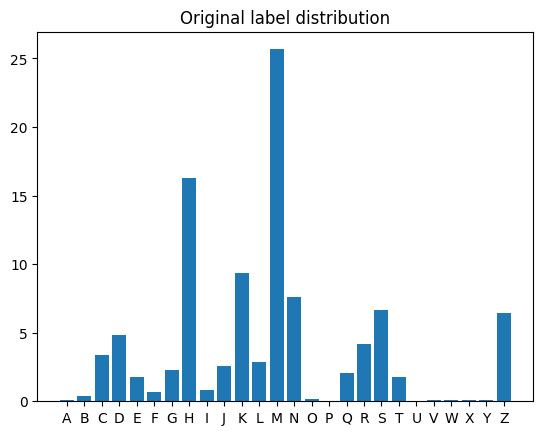

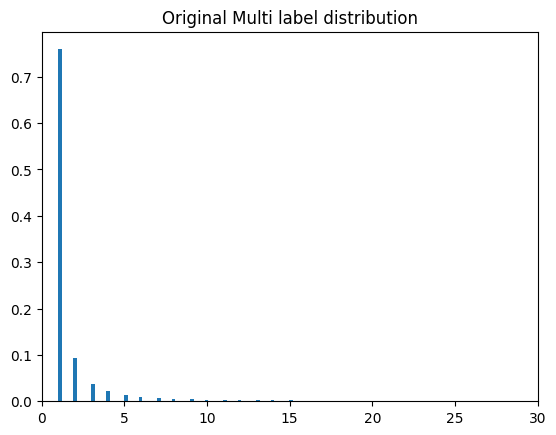

0it [00:00, ?it/s]

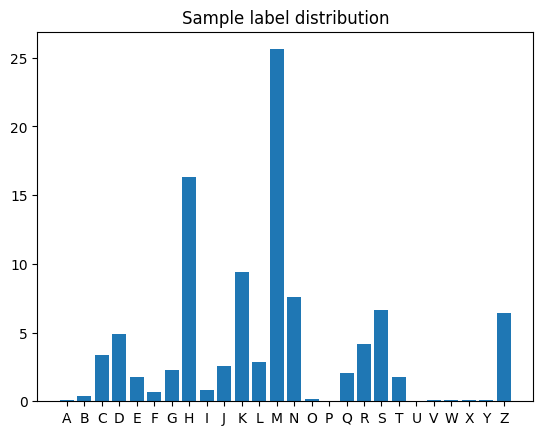

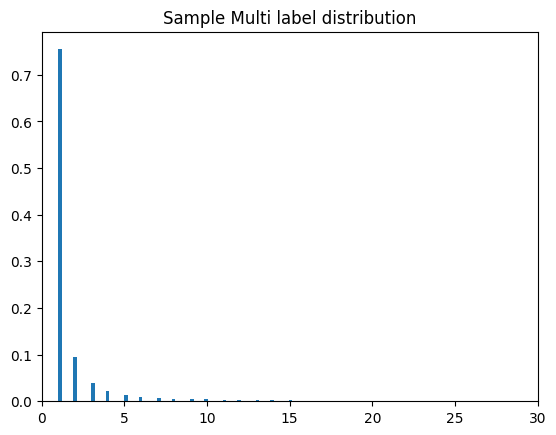

0it [00:51, ?it/s]


In [33]:
'''Utility code for stratified sampling of the dataset'''
# from skmultilearn.model_selection import IterativeStratification
# stratifier = IterativeStratification(n_splits=5, order=1)


# plt.figure(0)
# alphas = label_dist_true.keys()
# percents = np.fromiter(label_dist_true.values(),dtype = 'float32')
# percents = percents*100/np.sum(percents)
# plt.bar(alphas,percents)
# plt.title('Original label distribution')
# plt.show()

# #Need to check individual label is fixed
# clustering_count = Counter()
# for ml in y_labels_train:
#     clustering_count[ml] +=1

# plt.figure(1)
# plt.hist(clustering_count.values(),weights=np.ones(len(clustering_count.values())) / len(clustering_count.values()),bins = 10000)
# plt.title('Original Multi label distribution')
# plt.xlim(0,30)
# plt.show()

# # Split your dataset
# # print(stratifier.split(data_uni.iloc[:,:-1], data_uni.iloc[:,-1]))
# for train_indices,test_indices in tqdm(stratifier.split(X,y)):
#     X_train_sample, y_train_sample = X[train_indices], y[train_indices]
#     X_test_sample, y_test_sample =X[test_indices], y[test_indices]
#     y_train_labels_sample = mlb.inverse_transform(np.array(y_train_sample))
#     # print(y_train_labels[0])
#     label_dist_sample = labels_in_cluster(alphabets,y_train_labels_sample)
    
#     plt.figure(0)
#     alphas = label_dist_sample.keys()
#     percents = np.fromiter(label_dist_sample.values(),dtype = 'float32')
#     percents = percents*100/np.sum(percents)
#     plt.bar(alphas,percents)
#     plt.title('Sample label distribution')
#     plt.show()
#     #Need to check individual label is fixed
#     clustering_count = Counter()
#     for ml in y_train_labels_sample:
#         clustering_count[ml] +=1
    
#     plt.figure(1)
#     plt.hist(clustering_count.values(),weights=np.ones(len(clustering_count.values())) / len(clustering_count.values()),bins = 10000)
#     plt.title('Sample Multi label distribution')
#     plt.xlim(0,30)
#     plt.show()
#     break

In [13]:
final_length = np.sum(y_test,axis = 1)   #captures number of final labels assigned to each instance
letter_length = np.sum(y_test_letter,axis = 1) # captures number of letters assigned to each instance
print(Counter(final_length))
print(Counter(letter_length))

Counter({1: 17151, 2: 10874, 3: 5533, 4: 2843, 5: 1446, 6: 743, 7: 345, 8: 158, 9: 79, 10: 39, 11: 22, 12: 12, 14: 6, 13: 4, 16: 2, 15: 1})
Counter({1: 25959, 2: 10335, 3: 2572, 4: 349, 5: 39, 6: 4})


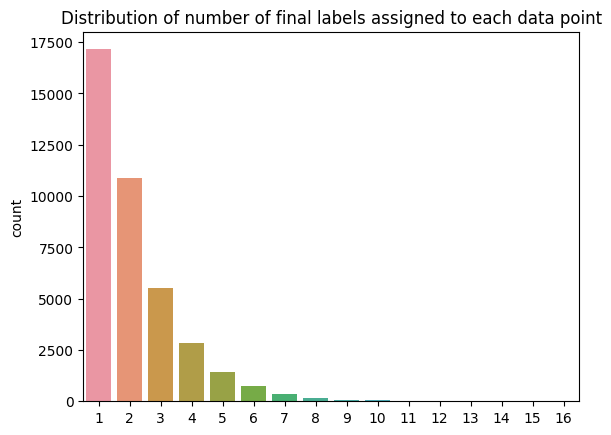

In [14]:
sns.countplot(x = final_length)
plt.title('Distribution of number of final labels assigned to each data point')
plt.show()

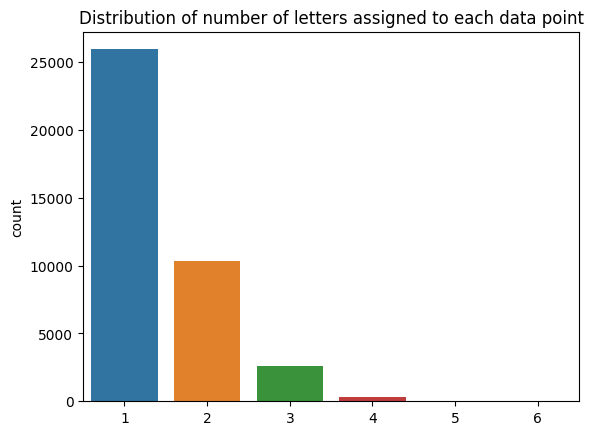

In [15]:
sns.countplot(x = letter_length)
plt.title('Distribution of number of letters assigned to each data point')
plt.show()

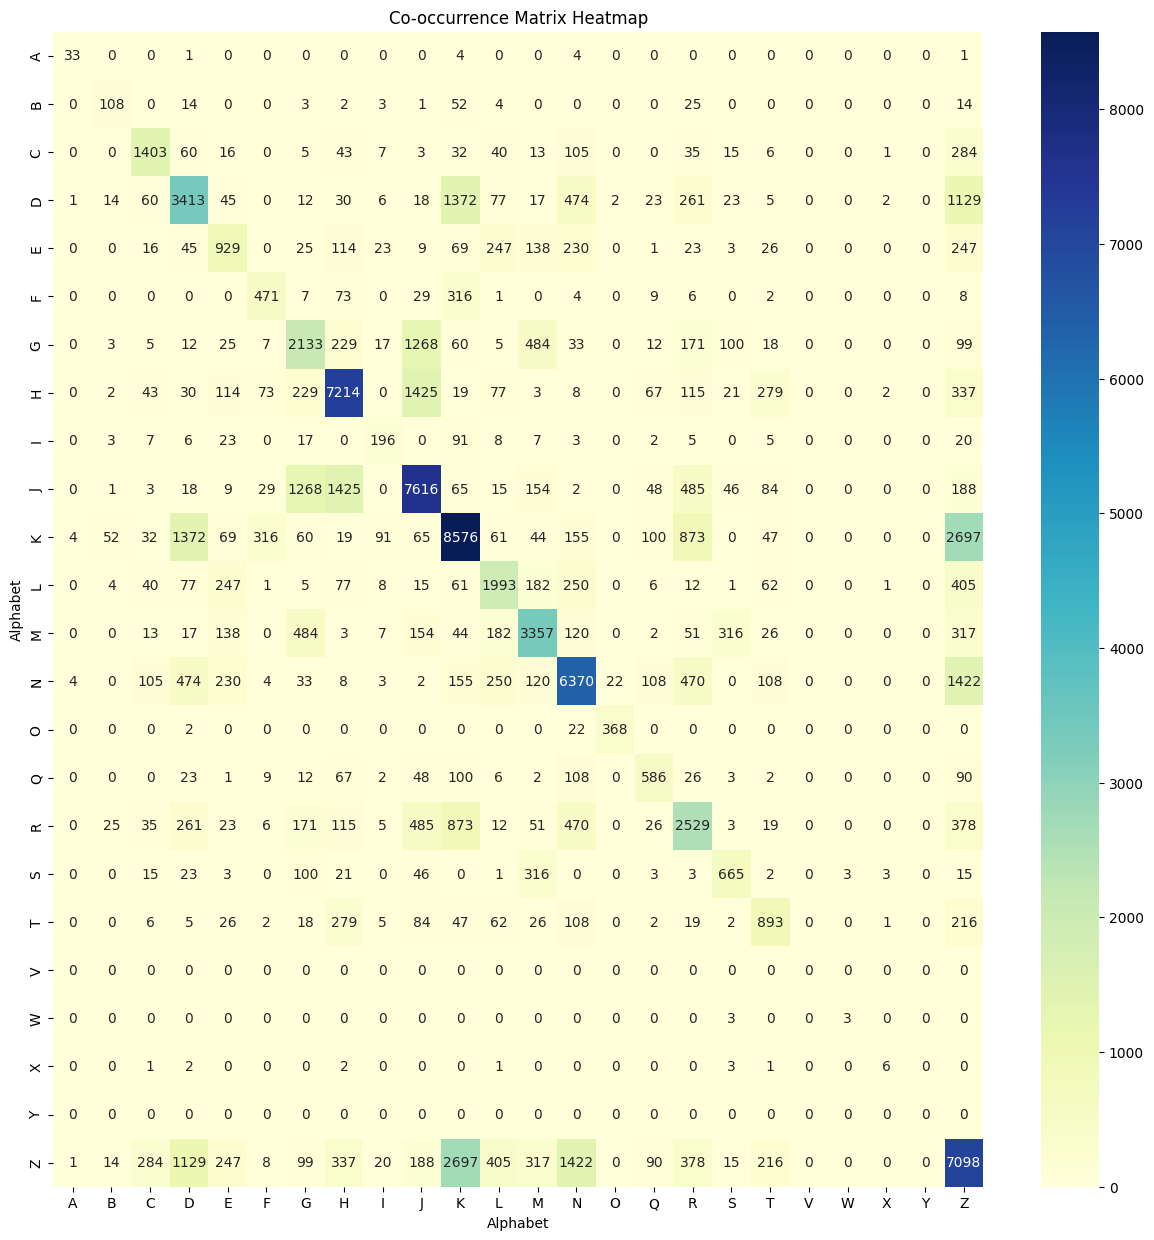

In [16]:
#co-occurence matrix
com = y_test_letter.T@y_test_letter
labels = [letter for letter in alphabets if letter!='P' and letter!='U']  # Replace with your actual labels

# Plotting the heatmap with custom labels
plt.figure(figsize=(15, 15))  # Adjust the figure size as needed
sns.heatmap(com, annot=True, fmt="d", cmap="YlGnBu", cbar=True,
            xticklabels=labels, yticklabels=labels)
plt.title("Co-occurrence Matrix Heatmap")
plt.xlabel("Alphabet")
plt.ylabel("Alphabet")
plt.show()

In [8]:
mlabels = mlb.classes_

In [9]:
gc.collect()

0

In [10]:
'''Custom micro f2 fucntion because Keras doesn't have one'''
@register_keras_serializable()
def micro_f2(y_true, y_pred):
    y_true = K.cast(y_true, tf.float32)
    y_pred = K.cast(y_pred > 0.5, tf.float32)  # Threshold to get binary predictions
    true_positives = K.sum(y_true * y_pred)
    possible_positives = K.sum(y_true)
    predicted_positives = K.sum(y_pred)
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f2 = (1 + 2**2) * (precision * recall) / (2**2 * precision + recall + K.epsilon())
    return f2




In [11]:
'''Model architecture'''
def build_model(input_length, num_labels, layer1 = 256, layer2 = 700, layer3 = 0.2):
    model = models.Sequential()
    model.add(layers.Input(shape=(1,input_length)))
    model.add(layers.Bidirectional(layers.GRU(layer1, return_sequences=True)))
    model.add(layers.Flatten())  # Flattening the output from the GRU layer
    model.add(layers.Dense(layer2, activation='relu'))
    model.add(layers.Dropout(layer3))
    model.add(layers.Dense(num_labels, activation='sigmoid'))  # Sigmoid for multi-label classification
    model.compile(optimizer='Adam',
                  loss='binary_crossentropy',
                  metrics=[micro_f2])

    return model

In [12]:
'''Custom grid search process using itertools'''
epochs1 = [5]
batch_sizes1 = [128]
es1 = [True]
callback =EarlyStopping(monitor='val_micro_f2',mode = 'max',patience=5)
params = list(itertools.product(epochs1,batch_sizes1,es1))


In [13]:
'''Iterating through the parameters and storing stage 1 predictions for stage 2'''
pred1s = []
for tup in tqdm(params):
    epoch,batch_size,es = tup
    stopper = []
    if es == True:
        stopper = callback
    model1 = build_model(X_train.shape[1],y_train_letter.shape[1])
    model1.fit(X_train.reshape(X_train.shape[0],1,X_train.shape[1]),y_train_letter, epochs = epoch, batch_size = batch_size,\
              callbacks = [callback], validation_data = (X_test.reshape(X_test.shape[0],1,X_test.shape[1]),y_test_letter))
    pred1s.append(model1.predict(real_test.reshape(real_test.shape[0],1,real_test.shape[1]))>0.5)
    

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/5
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0551 - micro_f2: 0.8180 - val_loss: 0.0238 - val_micro_f2: 0.9150
Epoch 2/5
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0218 - micro_f2: 0.9233 - val_loss: 0.0231 - val_micro_f2: 0.9209
Epoch 3/5
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0189 - micro_f2: 0.9333 - val_loss: 0.0226 - val_micro_f2: 0.9242
Epoch 4/5
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0163 - micro_f2: 0.9424 - val_loss: 0.0229 - val_micro_f2: 0.9264
Epoch 5/5
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0141 - micro_f2: 0.9503 - val_loss: 0.0239 - val_micro_f2: 0.9254
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


100%|██████████| 1/1 [00:54<00:00, 54.09s/it]


In [14]:
'''Custom function for filtering out data corresponding to single or a group of letters'''
def filter_data_points(embeddings,labels, labels_to_check):
    #choose rows who have atleast one entry in 'labels_to_check' and choose labels data only from 'labels_to_check' columns
    interested_rows = np.any(labels[:, labels_to_check], axis=1)
    interested_labels = labels[interested_rows]
    filtered_labels = np.zeros((np.sum(interested_rows),labels.shape[1]))
    filtered_labels[:,labels_to_check] += interested_labels[:,labels_to_check] 
    filtered_embeddings = embeddings[interested_rows]
    return filtered_embeddings, filtered_labels

In [15]:
'''Tool for coupling letters'''
coupler = defaultdict(list)
coupler.update({'K':['B','I'],'N':['A'],'S':['V','W','X'],'T':['Y']})
coupled = list(let for set in coupler.values() for let in set)

In [16]:
'''Grid search for stage 2 using itertools'''
epochs2 = [20]
batch_sizes2 = [128]
params2 = list(itertools.product(epochs2,batch_sizes2))
early_stopping = EarlyStopping(monitor='micro_f2',mode = 'max', patience=5, restore_best_weights=True)

In [17]:
'''Second stage training'''
models2_all = []

for tup in tqdm(params2):
    epoch,batch_size = tup
    models2 = {}
    for letter in tqdm(alphabets):
        indices  = [ind for ind,s in enumerate(mlabels) if s.startswith(letter)]
        if len(indices) == 0 or letter in coupled:
            models2[letter] = []
            continue
        else:
            for sec_letter in coupler[letter]:
                sec_indices = [ind for ind,s in enumerate(mlabels) if s.startswith(sec_letter)]
                indices.extend(sec_indices)
            print(letter)
            print(coupler[letter])
            filtered_data,filtered_labels = filter_data_points(X_train,y_train,indices)
        
            filtered_valid_data,filtered_valid_labels = filter_data_points(X_test,y_test,indices)
            model = build_model(filtered_data.shape[1],len(indices))
            model.fit(filtered_data.reshape(filtered_data.shape[0],1,filtered_data.shape[1]),filtered_labels[:,indices],epochs = epoch,batch_size = batch_size,
                      callbacks = [],validation_data = (filtered_valid_data.reshape(filtered_valid_data.shape[0],1,filtered_valid_data.shape[1]),filtered_valid_labels[:,indices]))
            models2[letter] = model
            
    models2_all.append(models2)
    gc.collect()

  0%|          | 0/26 [00:00<?, ?it/s]

C
[]
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2154 - micro_f2: 0.2341 - val_loss: 0.0229 - val_micro_f2: 0.7633
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0214 - micro_f2: 0.7930 - val_loss: 0.0161 - val_micro_f2: 0.8537
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0158 - micro_f2: 0.8579 - val_loss: 0.0154 - val_micro_f2: 0.8615
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0140 - micro_f2: 0.8756 - val_loss: 0.0148 - val_micro_f2: 0.8870
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0114 - micro_f2: 0.9003 - val_loss: 0.0140 - val_micro_f2: 0.8779
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0099 - micro_f2: 0.9142 - val_loss: 0.0147 - val_micro_f2: 0.8790
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0092 - micro_f2: 0.9218 - val_loss: 0.0141 - val_micro_f2: 0.8815
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - micro_f2: 0.9347 - val_loss: 0.0153 - val_mic


 12%|█▏        | 3/26 [00:08<01:06,  2.89s/it]

D
[]
Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1510 - micro_f2: 0.2580 - val_loss: 0.0189 - val_micro_f2: 0.7519
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0183 - micro_f2: 0.7811 - val_loss: 0.0148 - val_micro_f2: 0.8179
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0144 - micro_f2: 0.8326 - val_loss: 0.0142 - val_micro_f2: 0.8206
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0123 - micro_f2: 0.8548 - val_loss: 0.0138 - val_micro_f2: 0.8404
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0106 - micro_f2: 0.8785 - val_loss: 0.0137 - val_micro_f2: 0.8355
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095 - micro_f2: 0.8938 - val_loss: 0.0142 - val_micro_f2: 0.8273
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0086 - micro_f2: 0.9012 - val_loss: 0.0143 - val_micro_f2: 0.8346
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0077 - micro_f2: 0.9108 - val_loss: 0


 15%|█▌        | 4/26 [00:25<02:41,  7.33s/it]

E
[]
Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.2452 - micro_f2: 0.4311 - val_loss: 0.0359 - val_micro_f2: 0.7808
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0343 - micro_f2: 0.8062 - val_loss: 0.0241 - val_micro_f2: 0.8770
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0248 - micro_f2: 0.8741 - val_loss: 0.0226 - val_micro_f2: 0.8957
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0185 - micro_f2: 0.9072 - val_loss: 0.0211 - val_micro_f2: 0.9121
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0158 - micro_f2: 0.9309 - val_loss: 0.0226 - val_micro_f2: 0.9066
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0144 - micro_f2: 0.9339 - val_loss: 0.0214 - val_micro_f2: 0.9119
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0130 - micro_f2: 0.9427 - val_loss: 0.0212 - val_micro_f2: 0.9111
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0110 - micro_f2: 0.9507 - val_loss: 0.0205 - val_mic


 19%|█▉        | 5/26 [00:32<02:34,  7.37s/it]

F
[]
Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2956 - micro_f2: 0.6204 - val_loss: 0.1180 - val_micro_f2: 0.7931
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0868 - micro_f2: 0.8393 - val_loss: 0.1183 - val_micro_f2: 0.8356
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0750 - micro_f2: 0.8667 - val_loss: 0.0946 - val_micro_f2: 0.8186
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0709 - micro_f2: 0.8863 - val_loss: 0.1090 - val_micro_f2: 0.8176
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0700 - micro_f2: 0.8717 - val_loss: 0.0979 - val_micro_f2: 0.8255
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0589 - micro_f2: 0.8977 - val_loss: 0.0921 - val_micro_f2: 0.8414
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0567 - micro_f2: 0.9094 - val_loss: 0.0881 - val_micro_f2: 0.8467
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0610 - micro_f2: 0.8940 - val_loss: 0.0986 - val_mic


 23%|██▎       | 6/26 [00:37<02:13,  6.67s/it]

G
[]
Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1539 - micro_f2: 0.5624 - val_loss: 0.0168 - val_micro_f2: 0.8916
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0176 - micro_f2: 0.8976 - val_loss: 0.0138 - val_micro_f2: 0.9079
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0150 - micro_f2: 0.9123 - val_loss: 0.0133 - val_micro_f2: 0.9214
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0136 - micro_f2: 0.9180 - val_loss: 0.0124 - val_micro_f2: 0.9196
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0123 - micro_f2: 0.9276 - val_loss: 0.0123 - val_micro_f2: 0.9260
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0107 - micro_f2: 0.9356 - val_loss: 0.0125 - val_micro_f2: 0.9227
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - micro_f2: 0.9420 - val_loss: 0.0123 - val_micro_f2: 0.9172
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098 - micro_f2: 0.9398 - val_loss: 0.0128 - val_mic


 27%|██▋       | 7/26 [00:49<02:33,  8.10s/it]

H
[]
Epoch 1/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0888 - micro_f2: 0.2184 - val_loss: 0.0103 - val_micro_f2: 0.6242
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0108 - micro_f2: 0.6333 - val_loss: 0.0085 - val_micro_f2: 0.6905
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0088 - micro_f2: 0.7006 - val_loss: 0.0080 - val_micro_f2: 0.7267
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0080 - micro_f2: 0.7280 - val_loss: 0.0078 - val_micro_f2: 0.7371
Epoch 5/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0073 - micro_f2: 0.7487 - val_loss: 0.0077 - val_micro_f2: 0.7421
Epoch 6/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0070 - micro_f2: 0.7597 - val_loss: 0.0076 - val_micro_f2: 0.7444
Epoch 7/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0065 - micro_f2: 0.7751 - val_loss: 0.0076 - val_micro_f2: 0.7544
Epoch 8/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0062 - micro_f2: 0.7835 - val_loss: 0


 31%|███       | 8/26 [01:21<04:36, 15.38s/it]

J
[]
Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0968 - micro_f2: 0.6851 - val_loss: 0.0343 - val_micro_f2: 0.8647
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0322 - micro_f2: 0.8597 - val_loss: 0.0324 - val_micro_f2: 0.8479
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0292 - micro_f2: 0.8718 - val_loss: 0.0316 - val_micro_f2: 0.8643
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0268 - micro_f2: 0.8798 - val_loss: 0.0314 - val_micro_f2: 0.8719
Epoch 5/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0254 - micro_f2: 0.8888 - val_loss: 0.0318 - val_micro_f2: 0.8664
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0239 - micro_f2: 0.8943 - val_loss: 0.0322 - val_micro_f2: 0.8693
Epoch 7/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0232 - micro_f2: 0.8979 - val_loss: 0.0323 - val_micro_f2: 0.8663
Epoch 8/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0214 - micro_f2: 0.9040 - val_loss: 0


 38%|███▊      | 10/26 [01:54<04:16, 16.05s/it]

K
['B', 'I']
Epoch 1/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0851 - micro_f2: 0.3546 - val_loss: 0.0123 - val_micro_f2: 0.7806
Epoch 2/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0117 - micro_f2: 0.7838 - val_loss: 0.0102 - val_micro_f2: 0.8210
Epoch 3/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0095 - micro_f2: 0.8313 - val_loss: 0.0092 - val_micro_f2: 0.8459
Epoch 4/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0081 - micro_f2: 0.8585 - val_loss: 0.0089 - val_micro_f2: 0.8546
Epoch 5/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0072 - micro_f2: 0.8753 - val_loss: 0.0088 - val_micro_f2: 0.8594
Epoch 6/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0063 - micro_f2: 0.8904 - val_loss: 0.0087 - val_micro_f2: 0.8616
Epoch 7/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0055 - micro_f2: 0.9053 - val_loss: 0.0091 - val_micro_f2: 0.8524
Epoch 8/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0048 - micro_f2: 0.9169 - val


 42%|████▏     | 11/26 [02:33<05:24, 21.66s/it]

L
[]
Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2019 - micro_f2: 0.2812 - val_loss: 0.0468 - val_micro_f2: 0.5664
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0472 - micro_f2: 0.6160 - val_loss: 0.0403 - val_micro_f2: 0.6829
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0400 - micro_f2: 0.6838 - val_loss: 0.0389 - val_micro_f2: 0.6810
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0366 - micro_f2: 0.7006 - val_loss: 0.0387 - val_micro_f2: 0.6911
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0327 - micro_f2: 0.7339 - val_loss: 0.0384 - val_micro_f2: 0.6878
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0301 - micro_f2: 0.7490 - val_loss: 0.0385 - val_micro_f2: 0.6993
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0270 - micro_f2: 0.7756 - val_loss: 0.0396 - val_micro_f2: 0.6954
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0246 - micro_f2: 0.8028 - val_loss: 0.0410 - val_mic


 46%|████▌     | 12/26 [02:45<04:26, 19.03s/it]

M
[]
Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1423 - micro_f2: 0.1481 - val_loss: 0.0122 - val_micro_f2: 0.5124
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0110 - micro_f2: 0.5684 - val_loss: 0.0077 - val_micro_f2: 0.6968
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0077 - micro_f2: 0.7066 - val_loss: 0.0063 - val_micro_f2: 0.7554
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0060 - micro_f2: 0.7673 - val_loss: 0.0056 - val_micro_f2: 0.7897
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0051 - micro_f2: 0.8045 - val_loss: 0.0052 - val_micro_f2: 0.8157
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0044 - micro_f2: 0.8337 - val_loss: 0.0050 - val_micro_f2: 0.8136
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0038 - micro_f2: 0.8554 - val_loss: 0.0048 - val_micro_f2: 0.8301
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036 - micro_f2: 0.8617 - val_loss: 0


 50%|█████     | 13/26 [03:01<03:59, 18.45s/it]

N
['A']
Epoch 1/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1028 - micro_f2: 0.3351 - val_loss: 0.0143 - val_micro_f2: 0.7623
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0134 - micro_f2: 0.7740 - val_loss: 0.0123 - val_micro_f2: 0.7967
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0111 - micro_f2: 0.8191 - val_loss: 0.0118 - val_micro_f2: 0.8205
Epoch 4/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0100 - micro_f2: 0.8380 - val_loss: 0.0118 - val_micro_f2: 0.8143
Epoch 5/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0091 - micro_f2: 0.8526 - val_loss: 0.0117 - val_micro_f2: 0.8187
Epoch 6/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0082 - micro_f2: 0.8659 - val_loss: 0.0118 - val_micro_f2: 0.8226
Epoch 7/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0076 - micro_f2: 0.8801 - val_loss: 0.0118 - val_micro_f2: 0.8269
Epoch 8/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0067 - micro_f2: 0.8942 - val_loss


 54%|█████▍    | 14/26 [03:30<04:15, 21.30s/it]

O
[]
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.2706 - micro_f2: 0.9211 - val_loss: 0.0769 - val_micro_f2: 0.9764
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0584 - micro_f2: 0.9763 - val_loss: 0.0759 - val_micro_f2: 0.9719
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0607 - micro_f2: 0.9750 - val_loss: 0.0813 - val_micro_f2: 0.9755
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0544 - micro_f2: 0.9797 - val_loss: 0.0763 - val_micro_f2: 0.9759
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0427 - micro_f2: 0.9832 - val_loss: 0.0891 - val_micro_f2: 0.9749
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0552 - micro_f2: 0.9800 - val_loss: 0.0761 - val_micro_f2: 0.9760
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0411 - micro_f2: 0.9850 - val_loss: 0.0772 - val_micro_f2: 0.9755
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0414 - micro_f2: 0.9846 - val_loss: 0.0805 - val_mic


 58%|█████▊    | 15/26 [03:35<03:02, 16.57s/it]

Q
[]
Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.3146 - micro_f2: 0.3571 - val_loss: 0.0381 - val_micro_f2: 0.8271
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0336 - micro_f2: 0.8304 - val_loss: 0.0164 - val_micro_f2: 0.8985
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0150 - micro_f2: 0.9095 - val_loss: 0.0115 - val_micro_f2: 0.9284
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0110 - micro_f2: 0.9401 - val_loss: 0.0096 - val_micro_f2: 0.9352
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - micro_f2: 0.9555 - val_loss: 0.0086 - val_micro_f2: 0.9568
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - micro_f2: 0.9708 - val_loss: 0.0089 - val_micro_f2: 0.9452
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - micro_f2: 0.9759 - val_loss: 0.0099 - val_micro_f2: 0.9396
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - micro_f2: 0.9751 - val_loss: 0.0093 - val_mic


 65%|██████▌   | 17/26 [03:40<01:33, 10.39s/it]

R
[]
Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1758 - micro_f2: 0.2575 - val_loss: 0.0229 - val_micro_f2: 0.7141
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0201 - micro_f2: 0.7656 - val_loss: 0.0149 - val_micro_f2: 0.8417
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0133 - micro_f2: 0.8573 - val_loss: 0.0127 - val_micro_f2: 0.8619
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0107 - micro_f2: 0.8874 - val_loss: 0.0120 - val_micro_f2: 0.8749
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0090 - micro_f2: 0.9058 - val_loss: 0.0119 - val_micro_f2: 0.8797
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0072 - micro_f2: 0.9265 - val_loss: 0.0122 - val_micro_f2: 0.8841
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - micro_f2: 0.9402 - val_loss: 0.0125 - val_micro_f2: 0.8724
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - micro_f2: 0.9447 - val_loss: 0.0121 - val_mic


 69%|██████▉   | 18/26 [03:53<01:27, 11.00s/it]

S
['V', 'W', 'X']
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.3289 - micro_f2: 0.0968 - val_loss: 0.0580 - val_micro_f2: 0.3739
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0471 - micro_f2: 0.3963 - val_loss: 0.0275 - val_micro_f2: 0.5447
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0249 - micro_f2: 0.5724 - val_loss: 0.0193 - val_micro_f2: 0.6666
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0175 - micro_f2: 0.6871 - val_loss: 0.0155 - val_micro_f2: 0.7498
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0138 - micro_f2: 0.7504 - val_loss: 0.0133 - val_micro_f2: 0.7861
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0111 - micro_f2: 0.8044 - val_loss: 0.0121 - val_micro_f2: 0.8124
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0095 - micro_f2: 0.8490 - val_loss: 0.0110 - val_micro_f2: 0.8260
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - micro_f2: 0.8653 - val_loss: 0.0


 73%|███████▎  | 19/26 [03:59<01:08,  9.72s/it]

T
['Y']
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.2874 - micro_f2: 0.2383 - val_loss: 0.0621 - val_micro_f2: 0.6031
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0564 - micro_f2: 0.6569 - val_loss: 0.0459 - val_micro_f2: 0.7067
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0435 - micro_f2: 0.7277 - val_loss: 0.0424 - val_micro_f2: 0.7565
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0372 - micro_f2: 0.7757 - val_loss: 0.0427 - val_micro_f2: 0.7546
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0358 - micro_f2: 0.7857 - val_loss: 0.0392 - val_micro_f2: 0.7669
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0322 - micro_f2: 0.8108 - val_loss: 0.0401 - val_micro_f2: 0.7823
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0288 - micro_f2: 0.8314 - val_loss: 0.0398 - val_micro_f2: 0.7820
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0253 - micro_f2: 0.8557 - val_loss: 0.0421 - val_


 77%|███████▋  | 20/26 [04:06<00:53,  8.99s/it]

Z
[]
Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0879 - micro_f2: 0.5598 - val_loss: 0.0106 - val_micro_f2: 0.8458
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0101 - micro_f2: 0.8599 - val_loss: 0.0092 - val_micro_f2: 0.8734
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0081 - micro_f2: 0.8884 - val_loss: 0.0087 - val_micro_f2: 0.8759
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0068 - micro_f2: 0.9042 - val_loss: 0.0085 - val_micro_f2: 0.8833
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0059 - micro_f2: 0.9180 - val_loss: 0.0085 - val_micro_f2: 0.8813
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050 - micro_f2: 0.9320 - val_loss: 0.0090 - val_micro_f2: 0.8811
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0043 - micro_f2: 0.9409 - val_loss: 0.0088 - val_micro_f2: 0.8875
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - micro_f2: 0.9530 - val_loss: 0


100%|██████████| 1/1 [04:38<00:00, 278.53s/it]


In [18]:
gc.collect()

0

In [25]:
'''Final model train performance'''
pred_train = model1.predict(X_train.reshape(X_train.shape[0],1,X_train.shape[1]))>0.5
print(micro_f2(final_pred(X_train.reshape(X_train.shape[0],1,X_train.shape[1]),pred_train,mlabels,models2),y_train))

4893/4893 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


  0%|          | 0/26 [00:00<?, ?it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 12%|█▏        | 3/26 [00:00<00:03,  6.17it/s]

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 15%|█▌        | 4/26 [00:01<00:12,  1.83it/s]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 19%|█▉        | 5/26 [00:02<00:10,  2.07it/s]

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 23%|██▎       | 6/26 [00:02<00:07,  2.54it/s]

258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 27%|██▋       | 7/26 [00:03<00:09,  1.96it/s]

899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


 31%|███       | 8/26 [00:05<00:21,  1.19s/it]

961/961 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


 38%|███▊      | 10/26 [00:08<00:20,  1.28s/it]

1075/1075 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


 42%|████▏     | 11/26 [00:11<00:26,  1.78s/it]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 46%|████▌     | 12/26 [00:12<00:20,  1.49s/it]

412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 50%|█████     | 13/26 [00:13<00:18,  1.43s/it]

807/807 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 54%|█████▍    | 14/26 [00:16<00:20,  1.69s/it]

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 58%|█████▊    | 15/26 [00:16<00:13,  1.26s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 65%|██████▌   | 17/26 [00:16<00:06,  1.34it/s]

279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 69%|██████▉   | 18/26 [00:17<00:06,  1.32it/s]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 73%|███████▎  | 19/26 [00:17<00:04,  1.58it/s]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 77%|███████▋  | 20/26 [00:18<00:03,  1.81it/s]

819/819 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


100%|██████████| 26/26 [00:20<00:00,  1.28it/s]


tf.Tensor(0.95551986, shape=(), dtype=float32)


In [19]:
'''Utility function for 2nd stage prediction'''
def final_pred(X_test,pred_1,mlabels,models):
    pred_2 = np.zeros((X_test.shape[0],len(mlabels)))
    ind = 0
    for letter in tqdm(alphabets):
        indices  = [ind for ind,s in enumerate(mlabels) if s.startswith(letter)]

        if letter == 'P' or letter == 'U':
            continue
        reqd_data = np.any(pred_1[:,ind].reshape(-1,1),axis = 1)  #all rows where the pred_1 is 1 for the given letter
        reqd_model = models[letter]
        X_reqd = X_test[reqd_data,:]
        ind +=1
        if np.sum(reqd_data) == 0:
            continue
        elif letter in coupled:
            continue
        else:
            for sec_letter in coupler[letter]:
                sec_indices = [ind for ind,s in enumerate(mlabels) if s.startswith(sec_letter)]
                indices.extend(sec_indices)

            pred_2[np.ix_(reqd_data,indices)] += reqd_model.predict(X_reqd)>0.5               
                
    return pred_2

In [24]:
'''Final model validation performance'''
pred_valid = model1.predict(X_test.reshape(X_test.shape[0],1,X_test.shape[1]))>0.5
print(micro_f2(final_pred(X_test.reshape(X_test.shape[0],1,X_test.shape[1]),pred_valid,mlabels,models2),y_test))

1227/1227 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


  0%|          | 0/26 [00:00<?, ?it/s]

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 12%|█▏        | 3/26 [00:00<00:01, 17.60it/s]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 5/26 [00:00<00:03,  6.96it/s]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 27%|██▋       | 7/26 [00:00<00:02,  6.84it/s]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 31%|███       | 8/26 [00:01<00:04,  3.84it/s]

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 38%|███▊      | 10/26 [00:02<00:04,  3.57it/s]

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 42%|████▏     | 11/26 [00:03<00:05,  2.52it/s]

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 46%|████▌     | 12/26 [00:03<00:04,  2.86it/s]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 50%|█████     | 13/26 [00:03<00:04,  2.85it/s]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 54%|█████▍    | 14/26 [00:04<00:04,  2.43it/s]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 17/26 [00:04<00:02,  4.41it/s]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 69%|██████▉   | 18/26 [00:04<00:01,  4.38it/s]

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 19/26 [00:04<00:01,  4.94it/s]

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 20/26 [00:04<00:01,  5.47it/s]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


100%|██████████| 26/26 [00:05<00:00,  4.79it/s]


tf.Tensor(0.83781624, shape=(), dtype=float32)


In [20]:
gc.collect()

0

In [21]:
'''Final prediction and conversion into csv file'''
for param,pred_1 in zip(params,pred1s):
    for param2,models2 in zip(params2,models2_all):
        pred_2 = mlb.inverse_transform(final_pred(real_test.reshape(real_test.shape[0],1,real_test.shape[1]),pred_1,mlabels,models2))
        empty_pred = [i for i,pred in enumerate(pred_2) if pred == ()]
        filename = f"output_exc_less_freq:{param},2:{param2}.csv"
        print(f"{filename} has {len(empty_pred)} empty values")
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["id", "labels"])
            for idx, labels in enumerate(pred_2, start=1):
                writer.writerow([idx, ";".join(labels)])
        print(f"Data saved to {filename}")
        gc.collect()
        

  0%|          | 0/26 [00:00<?, ?it/s]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 12%|█▏        | 3/26 [00:00<00:03,  7.65it/s]

514/514 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 15%|█▌        | 4/26 [00:02<00:14,  1.50it/s]

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


 19%|█▉        | 5/26 [00:02<00:12,  1.71it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 23%|██▎       | 6/26 [00:02<00:10,  1.93it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 27%|██▋       | 7/26 [00:03<00:11,  1.60it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 31%|███       | 8/26 [00:04<00:09,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 38%|███▊      | 10/26 [00:04<00:06,  2.64it/s]

1421/1421 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 42%|████▏     | 11/26 [00:09<00:21,  1.45s/it]

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


 46%|████▌     | 12/26 [00:09<00:16,  1.18s/it]

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


 50%|█████     | 13/26 [00:12<00:22,  1.77s/it]

169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 54%|█████▍    | 14/26 [00:13<00:17,  1.50s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


 65%|██████▌   | 17/26 [00:14<00:06,  1.31it/s]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 69%|██████▉   | 18/26 [00:14<00:05,  1.41it/s]

490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 73%|███████▎  | 19/26 [00:16<00:06,  1.08it/s]

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


 77%|███████▋  | 20/26 [00:16<00:04,  1.23it/s]

988/988 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


100%|██████████| 26/26 [00:19<00:00,  1.30it/s]


output_exc_less_freq:(5, 128, True),2:(20, 128).csv has 3097 empty values
Data saved to output_exc_less_freq:(5, 128, True),2:(20, 128).csv
